In [101]:
import torch
from torch_geometric.data import Data
from torch_geometric.datasets import KarateClub
from torch_geometric.utils import to_networkx
from tqdm.auto import tqdm
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

import os.path as osp

import torch
from torch_geometric.data import Dataset, download_url, InMemoryDataset
from torch_geometric.io import fs

import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import ChebConv
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

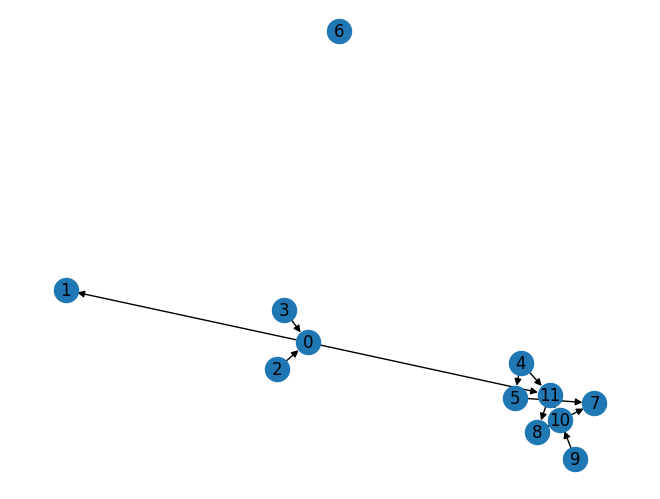

In [69]:
class LUCAS0Dataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(LUCAS0Dataset, self).__init__(root, transform, pre_transform)
        self.data = fs.torch_load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return ['lucas0_train.csv']

    @property
    def processed_file_names(self):
        return ['data.pt']

    def download(self):
        # Download to `self.raw_dir`.
        download_url('https://www.causality.inf.ethz.ch/data/lucas0_train.csv', self.raw_dir)

    def process(self):
        print(self.processed_paths)
        # Load in the data
        self.data = pd.read_csv(self.raw_paths[0])
        
        # Get the node features
        self._get_node_features()
        
        # Get the edge index
        self._get_edge_index()
    
        # Get the labels
        self._get_labels()
        
        # Save the data
        data = Data(x=self.X, edge_index=self.edge_index, y=self.y)
        
        # Save the data
        torch.save(data, osp.join(self.processed_dir, 'data.pt'))
        
        
    def _get_node_features(self):
        self.X = torch.tensor(self.data.values, dtype=torch.float).t()
        
    
    def _get_edge_index(self):
        from_list = [2, 3, 0, 0 , 4 , 4, 5, 11, 11, 9 , 10, 8]
        to_list   = [0, 0, 1, 11, 11, 5, 7, 10, 8 , 10, 8 , 7]
        self.edges = [(i, j) for i, j in zip(from_list, to_list)]  # Connect all nodes
        self.edge_index = torch.tensor(self.edges, dtype=torch.long).t().contiguous()
    
    
    def _get_labels(self):
        self.y = torch.tensor(self.data.Lung_cancer.values, dtype=torch.float)        


    def len(self):
        return len(self.processed_file_names)

dataset = LUCAS0Dataset(root='data/')[0]

# Visualize the graph
G = to_networkx(dataset)
nx.draw(G, with_labels=True)
plt.show()

In [70]:
df = pd.read_csv('data/raw/lucas0_train.csv')

In [71]:
print(df.columns)

Index(['Smoking', 'Yellow_Fingers', 'Anxiety', 'Peer_Pressure', 'Genetics',
       'Attention_Disorder', 'Born_an_Even_Day', 'Car_Accident', 'Fatigue',
       'Allergy', 'Coughing', 'Lung_cancer'],
      dtype='object')


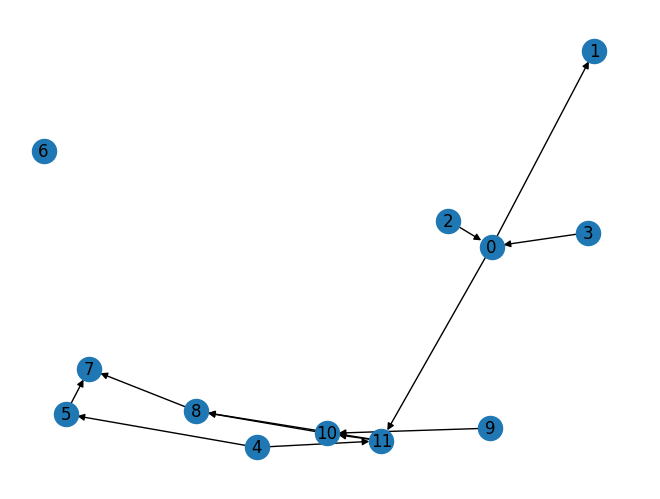

In [72]:
# Your tabular data
tabular_data = df.values

from_list = [2, 3, 0, 0, 4, 4, 5, 11, 11, 9, 10, 8]
to_list   = [0, 0, 1, 11, 11, 5, 7, 10, 8, 10, 8, 7]

# Create graph data
edges = [(i, j) for i, j in zip(from_list, to_list)]  # Connect all nodes
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

# Node features
x = torch.tensor(tabular_data, dtype=torch.float).t()
y = torch.tensor(df.Lung_cancer.values, dtype=torch.float)

# Assuming there are no node labels or edge features in this example
data = Data(x=x, edge_index=edge_index, y=y)

# Plot the data using networkx
G = to_networkx(data)
nx.draw(G, with_labels=True)

In [73]:
print(data)

Data(x=[12, 2000], edge_index=[2, 12], y=[2000])


In [97]:
#graph neural network class 
class GCN_c(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(GCN_c, self).__init__()
        self.conv1 = GCNConv(input_dim, 64)
        self.conv2 = GCNConv(64, 128)
        self.conv3 = GCNConv(128, 256)
        self.conv4 = GCNConv(256, 128)
        self.conv5 = GCNConv(128, output_dim)

    def forward(self, x, edge_index):
        # Apply first graph convolution
        x = x.t()
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)    
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv4(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)    

        # Apply second graph convolution
        x = self.conv5(x, edge_index)
        return x

#train model function
def train_model(model, data, epochs=20, del_labels = []):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    #x = np.delete(data.x, del_labels, axis = 1)
    # Delete columns at specified indices
    result_tensor = torch.tensor(np.delete(data.edge_index.numpy(), del_labels, axis=1))

    # Delete corresponding rows
    result_tensor = result_tensor[result_tensor[:, :].sum(dim=1) != 0]

    model.train()
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(x, result_tensor)
        loss = criterion(out.squeeze(), data.y)
        loss.backward()
        optimizer.step()

        #if epoch % 10 == 0:
            #print(f'Epoch {epoch}, Loss: {loss.item()}')

#predict function 
def predict(model, data, del_labels):
    model.eval()
    x = np.delete(data.x, del_labels, axis = 1)
    # Delete columns at specified indices
    result_tensor = torch.tensor(np.delete(data.edge_index.numpy(), del_labels, axis=1))

    # Delete corresponding rows
    result_tensor = result_tensor[result_tensor[:, :].sum(dim=1) != 0]
    with torch.no_grad():
        out = model(x, result_tensor)
        predicted_labels = torch.sigmoid(out)  # Sigmoid activation for binary classification
        return predicted_labels


## Deleting one feature and then training

In [99]:
# Define model dimensions
input_dim = tabular_data.shape[1]  # Number of input features
hidden_dim = 64
output_dim = 1  # Assuming binary classification (e.g., Lung Cancer prediction)
labels = ['Smoking', 'Yellow_Fingers', 'Anxiety', 'Peer_Pressure', 'Genetics',
       'Attention_Disorder', 'Born_an_Even_Day', 'Car_Accident', 'Fatigue',
       'Allergy', 'Coughing', 'Lung_cancer']

for i in range(len(labels)-1):
    model = GCN_c(input_dim, output_dim)


    # Train the model
    train_model(model, data, epochs=200, del_labels = [i])

    # Make predictions
    predictions = predict(model, data, del_labels = [i])

    # Evaluate the model accuracy
    accuracy = ((predictions > 0.5) == data.y).sum().item() / data.y.shape[0]**2
    print("Deleted label: "+str(labels[i]))
    print(f'Accuracy: {accuracy}')


Deleted label: Smoking
Accuracy: 0.59820675
Deleted label: Yellow_Fingers
Accuracy: 0.59754225
Deleted label: Anxiety
Accuracy: 0.59798525
Deleted label: Peer_Pressure
Accuracy: 0.59842825
Deleted label: Genetics
Accuracy: 0.59798525
Deleted label: Attention_Disorder
Accuracy: 0.59798525
Deleted label: Born_an_Even_Day
Accuracy: 0.59798525
Deleted label: Car_Accident
Accuracy: 0.59798525
Deleted label: Fatigue
Accuracy: 0.59798525
Deleted label: Allergy
Accuracy: 0.59798525
Deleted label: Coughing
Accuracy: 0.59798525
Deleted label: Lung_cancer
Accuracy: 0.59798525


## Deleting two features 

In [100]:
# Define model dimensions
input_dim = tabular_data.shape[1]  # Number of input features
hidden_dim = 64
output_dim = 1  # Assuming binary classification (e.g., Lung Cancer prediction)
labels = ['Smoking', 'Yellow_Fingers', 'Anxiety', 'Peer_Pressure', 'Genetics',
       'Attention_Disorder', 'Born_an_Even_Day', 'Car_Accident', 'Fatigue',
       'Allergy', 'Coughing', 'Lung_cancer']

for i in range(len(labels)):
    for j in range(len(labels)):
        model = GCN_c(input_dim, output_dim)


        # Train the model
        train_model(model, data, epochs=200, del_labels = [i,j])

        # Make predictions
        predictions = predict(model, data, del_labels = [i,j])

        # Evaluate the model accuracy
        accuracy = ((predictions > 0.5) == data.y).sum().item() / data.y.shape[0]**2
        print("Deleted label: "+str(labels[i])+", "+str(labels[j]))
        print(f'Accuracy: {accuracy}')

Deleted label: Smoking, Smoking
Accuracy: 0.59820675
Deleted label: Smoking, Yellow_Fingers
Accuracy: 0.5980675
Deleted label: Smoking, Anxiety
Accuracy: 0.597846
Deleted label: Smoking, Peer_Pressure
Accuracy: 0.5980675
Deleted label: Smoking, Genetics
Accuracy: 0.597846
Deleted label: Smoking, Attention_Disorder
Accuracy: 0.597846
Deleted label: Smoking, Born_an_Even_Day
Accuracy: 0.597846
Deleted label: Smoking, Car_Accident
Accuracy: 0.597846
Deleted label: Smoking, Fatigue
Accuracy: 0.5980675
Deleted label: Smoking, Allergy
Accuracy: 0.5980675
Deleted label: Smoking, Coughing
Accuracy: 0.5980675
Deleted label: Smoking, Lung_cancer
Accuracy: 0.5980675
Deleted label: Yellow_Fingers, Smoking
Accuracy: 0.5980675
Deleted label: Yellow_Fingers, Yellow_Fingers
Accuracy: 0.59754225
Deleted label: Yellow_Fingers, Anxiety
Accuracy: 0.597846
Deleted label: Yellow_Fingers, Peer_Pressure
Accuracy: 0.5980675
Deleted label: Yellow_Fingers, Genetics
Accuracy: 0.5967385
Deleted label: Yellow_Finge

KeyboardInterrupt: 

## Visualizing feature importance 
this does not work well 

(2000, 1)


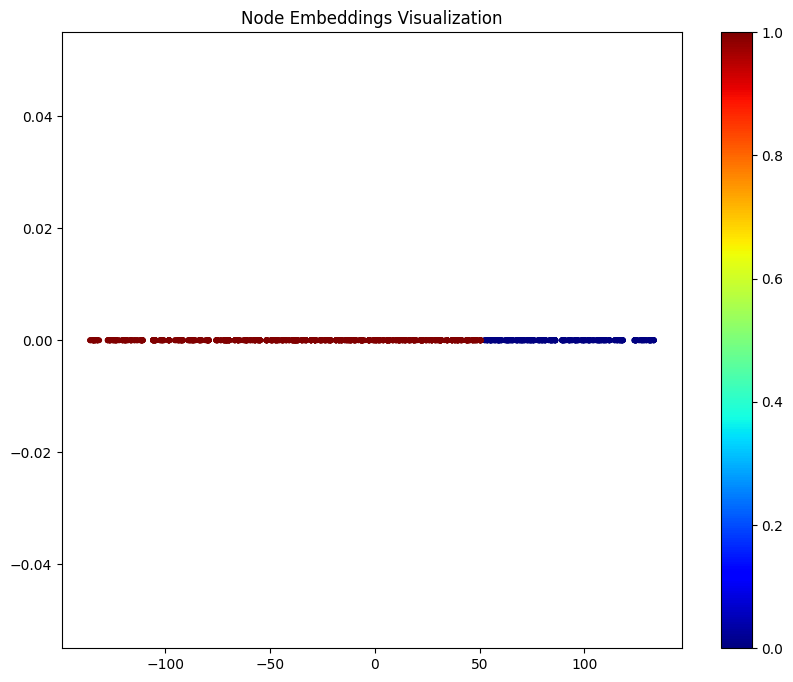

In [110]:

# Extract node embeddings
model.eval()
with torch.no_grad():
    node_embeddings = model(data.x, data.edge_index).detach().cpu().numpy()


# Reduce dimensionality for visualization
tsne = TSNE(n_components=1)
node_embeddings_2d = tsne.fit_transform(node_embeddings)
print(node_embeddings_2d.shape)

# Plot node embeddings
plt.figure(figsize=(10, 8))
domain = np.linspace(0,len(node_embeddings_2d),len(node_embeddings_2d))
zero = np.zeros(len(node_embeddings))
plt.scatter(node_embeddings_2d,zero, c=data.y.cpu(), cmap='jet', s=10)
plt.colorbar()
plt.title('Node Embeddings Visualization')
plt.show()

## Shap

In [128]:
import shap
import torch
from torch_geometric.data import Data

# Define a wrapper function for the GNN model
ind = data.edge_index
def model_wrapper(data):
    output = model(data, ind)  # Assuming model is your trained GNN model
    return output.detach().cpu().numpy()

# Create a background dataset (e.g., random noise)
background_data = torch.randn((1000, 12))

data_array = data.x.cpu().numpy() 

# Initialize an explainer object
explainer = shap.KernelExplainer(model_wrapper, data_array)


# Compute SHAP values
shap_values = explainer.shap_values(data.x, n_samples = 500)  # test_data should be a Data object containing the data you want to explain

# Visualize feature importance
shap.summary_plot(shap_values, features=data.x.numpy(), feature_names=['Smoking', 'Yellow_Fingers', 'Anxiety', 'Peer_Pressure', 'Genetics',
       'Attention_Disorder', 'Born_an_Even_Day', 'Car_Accident', 'Fatigue',
       'Allergy', 'Coughing', 'Lung_cancer']) 

Provided model function fails when applied to the provided data set.


AttributeError: 'numpy.ndarray' object has no attribute 't'

In [76]:
class GCN_ch(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(GCN_ch, self).__init__()
        K = 1
        self.conv1 = ChebConv(input_dim, 64, K)
        self.conv2 = ChebConv(64, 128, K)
        self.conv3 = ChebConv(128, 256, K)
        self.conv4 = ChebConv(256, 128, K)
        self.conv5 = ChebConv(128, output_dim, K)

    def forward(self, x, edge_index):
        # Apply first graph convolution
        x = x.t()
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)    
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv4(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)    

        # Apply second graph convolution
        x = self.conv5(x, edge_index)
        return x


In [77]:
# Define model dimensions
input_dim = tabular_data.shape[1]  # Number of input features
hidden_dim = 64
output_dim = 1  # Assuming binary classification (e.g., Lung Cancer prediction)
labels = ['Smoking', 'Yellow_Fingers', 'Anxiety', 'Peer_Pressure', 'Genetics',
       'Attention_Disorder', 'Born_an_Even_Day', 'Car_Accident', 'Fatigue',
       'Allergy', 'Coughing', 'Lung_cancer']
model = GCN_ch(input_dim, output_dim)


# Train the model
train_model(model, data, epochs=200)

# Make predictions
predictions = predict(model, data)
# Make predictions
print(predictions.shape)
# Evaluate the model accuracy
print(((predictions > 0.5) == data.y).shape)
print(data.y.shape[0])
accuracy = ((predictions > 0.5) == data.y).sum().item() / data.y.shape[0]**2
print(f'Accuracy: {accuracy}')



Epoch 0, Loss: 0.589248776435852
Epoch 10, Loss: 0.3279173672199249
Epoch 20, Loss: 0.03296194598078728
Epoch 30, Loss: 0.004584240727126598
Epoch 40, Loss: 0.0004491616564337164
Epoch 50, Loss: 0.001960489433258772
Epoch 60, Loss: 0.00011458498920546845
Epoch 70, Loss: 0.00016246194718405604
Epoch 80, Loss: 0.0010023309150710702
Epoch 90, Loss: 2.7543797841644846e-05
Epoch 100, Loss: 0.00018195142911281437
Epoch 110, Loss: 1.807408989407122e-05
Epoch 120, Loss: 9.789477189769968e-06
Epoch 130, Loss: 4.510272447078023e-06
Epoch 140, Loss: 6.581201432709349e-06
Epoch 150, Loss: 1.4909433048160281e-05
Epoch 160, Loss: 1.0453216418682132e-05
Epoch 170, Loss: 1.4396735423360951e-05
Epoch 180, Loss: 0.00030576062272302806
Epoch 190, Loss: 5.4511478083441034e-05
torch.Size([2000, 1])
torch.Size([2000, 2000])
2000
Accuracy: 0.5981245


## Gwens 

In [ ]:
class GraphConvolution(nn.Module):
    def __init__(self, in_features, out_features):
        super(GraphConvolution, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x, adj_matrix):
        """
        x: input node features (batch_size, num_nodes, in_features)
        adj_matrix: adjacency matrix (batch_size, num_nodes, num_nodes)
        """
        batch_size, num_nodes, _ = x.size()
        adj_matrix = adj_matrix.unsqueeze(3)  # Add dimension for broadcasting
        x = torch.matmul(adj_matrix, x)  # Aggregate neighbor features
        x = self.linear(x.view(-1, x.size(2)))  # Linear transformation
        x = F.relu(x)  # Activation function
        x = x.view(batch_size, num_nodes, -1)  # Reshape to original shape
        return x

class GraphClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GraphClassifier, self).__init__()
        self.conv1 = GraphConvolution(input_dim, hidden_dim)
        self.conv2 = GraphConvolution(hidden_dim, output_dim)

    def forward(self, x, adj_matrix):
        """
        x: input node features (batch_size, num_nodes, input_dim)
        adj_matrix: adjacency matrix (batch_size, num_nodes, num_nodes)
        """
        x = self.conv1(x, adj_matrix)
        x = self.conv2(x, adj_matrix)
        x = torch.mean(x, dim=1)  # Average pooling over nodes
        return F.log_softmax(x, dim=1)  # Log softmax for classification

# Example usage:
# Define input node features and adjacency matrix
input_dim = 32
hidden_dim = 64
output_dim = 2
batch_size = 32
num_nodes = 10

input_dim = tabular_data.shape[1]  # Number of input features
hidden_dim = 64
#model = GCN(input_dim, output_dim)

# Random node features and adjacency matrix (for demonstration purposes)
x = torch.randn(batch_size, num_nodes, input_dim)
adj_matrix = torch.randint(0, 2, (batch_size, num_nodes, num_nodes)).float()  # Random adjacency matrix

# Build and initialize the GNN model
model = GraphClassifier(input_dim, hidden_dim, output_dim)

# Forward pass
output = model(x, adj_matrix)
print("Output shape:", output.shape)